# Honey Production dataset analysis

[Source](https://www.kaggle.com/jessicali9530/honey-production)

## Context

In 2006, global concern was raised over the rapid decline in the honeybee population, an integral component to American honey agriculture. Large numbers of hives were lost to Colony Collapse Disorder, a phenomenon of disappearing worker bees causing the remaining hive colony to collapse. Speculation to the cause of this disorder points to hive diseases and pesticides harming the pollinators, though no overall consensus has been reached. Twelve years later, some industries are observing recovery but the American honey industry is still largely struggling. The U.S. used to locally produce over half the honey it consumes per year. Now, honey mostly comes from overseas, with 350 of the 400 million pounds of honey consumed every year originating from imports. This dataset provides insight into honey production supply and demand in America by state from 1998 to 2012.
Content

The National Agricultural Statistics Service (NASS) is the primary data reporting body for the US Department of Agriculture (USDA). NASS's mission is to "provide timely, accurate, and useful statistics in service to U.S. agriculture". From datasets to census surveys, their data covers virtually all aspects of U.S. agriculture. Honey production is one of the datasets offered. Click here for the original page containing the data along with related datasets such as Honey Bee Colonies and Cost of Pollination. Data wrangling was performed in order to clean the dataset. honeyproduction.csv is the final tidy dataset suitable for analysis. The three other datasets (which include "honeyraw" in the title) are the original raw data downloaded from the site. They are uploaded to this page along with the "Wrangling The Honey Production Dataset" kernel as an example to show users how data can be wrangled into a cleaner format. Useful metadata on certain variables of the honeyproduction dataset is provided below:

    numcol: Number of honey producing colonies. Honey producing colonies are the maximum number of colonies from which honey was taken during the year. It is possible to take honey from colonies which did not survive the entire year
    yieldpercol: Honey yield per colony. Unit is pounds
    totalprod: Total production (numcol x yieldpercol). Unit is pounds
    stocks: Refers to stocks held by producers. Unit is pounds
    priceperlb: Refers to average price per pound based on expanded sales. Unit is dollars.
    prodvalue: Value of production (totalprod x priceperlb). Unit is dollars.
    Other useful information: Certain states are excluded every year (ex. CT) to avoid disclosing data for individual operations. Due to rounding, total colonies multiplied by total yield may not equal production. Also, summation of states will not equal U.S. level value of production.

## Acknowledgements

Honey production data was published by the National Agricultural Statistics Service (NASS) of the U.S. Department of Agriculture. The beautiful banner photo was by Eric Ward on Unsplash.

## Inspiration

- How has honey production yield changed from 1998 to 2012?
- Over time, which states produce the most honey? Which produce the least? Which have experienced the most change in honey yield?
- Does the data show any trends in terms of the number of honey producing colonies and yield per colony before 2006, which was when concern over Colony Collapse Disorder spread nationwide?
- Are there any patterns that can be observed between total honey production and value of production every year? How has value of production, which in some sense could be tied to demand, changed every year?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools as ft

%matplotlib inline

Some quirks of the (raw) dataset:
- states are referred to as either their two-letter abbreviation or full name.
- number of rows per year change; depending on the year, some states are grouped under "Other States".
- Files `honeyraw_2003to2007.csv` and `honeyraw_2008to2012.csv` include three tables at the top about honey prices by color class, in addition to the general stats on honey production.

In [58]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
states_acronym = {i[1]:i[0] for i in states.items()}

In [87]:
def produce_tables_from_file(filepath):
    '''
    The method creates a list of dictionaries describing tables in Excel whose
    contents are marked in the first two columns. In the first column, a number
    marks the start and the end of a table, and in the second column, a letter
    is used to identify whether the (t)itle, (h)eader, (u)nits, (d)ata, (f)ooter
    or (c)losing/end is described in the other columns.
    
    Keyword arguments:
    
    filepath -- the path to the file (defaults to containing folder)
    
    Returns:
    
    list of dictionaries containing keys title, headers, units, data, footers. Data can be directly converted into a Pandas dataframe.
    '''
    tables = []
    tbl_ctr = None
    with open(filepath) as file_contents:
        freader = csv.reader(file_contents)
        num_columns = None
        tab_title = []
        tab_headers = []
        tab_units = []
        tab_data = []
        tab_footer = []
        for row in freader:
            if tbl_ctr != int(row[0]):
                tbl_ctr = int(row[0])
                if len(tab_title) > 0:
                    tables.append(dict(
                        title=tab_title,
                        headers=tab_headers,
                        units=tab_units,
                        data=tab_data,
                        footers=tab_footer
                    ))
                    num_columns = None
                    tab_title = []
                    tab_headers = []
                    tab_units = []
                    tab_data = []
                    tab_footer = []
            if row[1] in ['t', 'f']:
                tab_title.append(row[2])
            elif row[1] in ['h']:
                if num_columns is None:
                    num_columns = len(row[2:])
                    for i in range(0,num_columns):
                        tab_headers.append(row[2+i])
                else:
                    for i in range(0,num_columns):
                        tmp = "{}".format(row[2+i])
                        tab_headers[i] = '{}_{}'.format(tab_headers[i], tmp) if len(tmp) > 0 else tab_headers[i]
            elif row[1] in ['u']:
                assert len(row[2:]) == num_columns, "Column length doesn't match!"
                for i in range(0,num_columns):
                    tab_units.append(row[2+i])
            elif row[1] in ['d']:
                assert len(row[2:]) == num_columns, "Column length doesn't match!"
                tmp = dict()
                for i in range(0,num_columns):
                    tmp[tab_headers[i]] = int(row[2+i]) if row[2+i].isdigit() else row[2+i]
                tab_data.append(tmp)
    tables.append(dict(
        title=tab_title,
        headers=tab_headers,
        units=tab_units,
        data=tab_data,
        footers=tab_footer
    ))
    return tables

In [91]:
def get_dataframe(list_of_dicts, dropna=False, drop_how='any', index_field=None, suffix=None, transform_index=False, transform_dict={}):
    '''
    Produces a dataframe from a list of dictionaries interpretable by Pandas.
    It can make an index out of a column, add suffixes to all fields or
    transform the index when required with an input dictionary.
    
    Keyword arguments:
    
    list_of_dicts   -- a list that can be converted to a dataframe
    dropna          -- drop rows without contents (default: False)
    drop_how        -- defines drop strategy using similar dataframe approaches (default: 'any')
    index_field     -- indicates the field to become index (default: None)
    suffix          -- adds a suffix to all fields (default: None)
    transform_index -- requires an index field and a transform dictionary to convert a column value (default: False)
    transform_dict  -- converts a column value to the dictionary value, or leaves it if not found (default: {})
    
    Returns:
    
    a dataframe with transformations if requested.
    '''
    df = pd.DataFrame(list_of_dicts)
    if dropna:
        df.replace('', np.nan, regex=True, inplace=True)
        df.dropna(inplace=True, how=drop_how)
    if transform_index and index_field and transform_dict:
        index_field_ori = '{}_old'.format(index_field)
        df[index_field_ori] = df[index_field]
        df[index_field] = df[index_field_ori].apply(lambda x: transform_dict.get(x, x))
        df.drop(index_field_ori, axis=1, inplace=True)
    if index_field and index_field in df.columns:
        df.set_index(index_field, inplace=True)
    if suffix:
        df.columns = ['{}{}'.format(col, suffix) for col in df.columns]
    return df

In [103]:
src_9802 = produce_tables_from_file('./data/honeyraw_1998to2002.csv')
df_1998  = get_dataframe(src_9802[0].get('data', []), index_field='_State', suffix='_98', dropna=True)
df_1999  = get_dataframe(src_9802[1].get('data', []), index_field='_State', suffix='_99', dropna=True)
df_2000  = get_dataframe(src_9802[2].get('data', []), index_field='_State', suffix='_00', dropna=True)
df_2001  = get_dataframe(src_9802[3].get('data', []), index_field='_State', suffix='_01', dropna=True)
df_2002  = get_dataframe(src_9802[4].get('data', []), index_field='_State', suffix='_02', dropna=True)

src_0307 = produce_tables_from_file('./data/honeyraw_2003to2007.csv')
assert len(src_0307) == 8, "Unexpected number of tables"
fest_0304 = get_dataframe(src_0307[0].get('data', []), dropna=True, index_field='_Color Class')
fest_0506 = get_dataframe(src_0307[1].get('data', []), dropna=True, index_field='_Color Class')
fest_07   = get_dataframe(src_0307[2].get('data', []), dropna=True, index_field='_Color Class')
df_2003   = get_dataframe(src_0307[3].get('data', []), index_field='_State', suffix='_03', dropna=True)
df_2004   = get_dataframe(src_0307[4].get('data', []), index_field='_State', suffix='_04', dropna=True)
df_2005   = get_dataframe(src_0307[5].get('data', []), index_field='_State', suffix='_05', dropna=True)
df_2006   = get_dataframe(src_0307[6].get('data', []), index_field='_State', suffix='_06', dropna=True)
df_2007   = get_dataframe(src_0307[7].get('data', []), index_field='_State', suffix='_07', dropna=True)

src_0812 = produce_tables_from_file('./data/honeyraw_2008to2012.csv')
assert len(src_0812) == 8, "Unexpected number of tables"
fest_0809 = get_dataframe(src_0812[0].get('data', []), dropna=True, index_field='_Color class')
fest_1011 = get_dataframe(src_0812[1].get('data', []), dropna=True, index_field='_Color class')
fest_12   = get_dataframe(src_0812[2].get('data', []), dropna=True, index_field='_Color class')
df_2008   = get_dataframe(src_0812[3].get('data', []), index_field='_State', suffix='_08', transform_index=True, transform_dict=states_acronym, dropna=True)
df_2009   = get_dataframe(src_0812[4].get('data', []), index_field='_State', suffix='_09', transform_index=True, transform_dict=states_acronym, dropna=True)
df_2010   = get_dataframe(src_0812[5].get('data', []), index_field='_State', suffix='_10', transform_index=True, transform_dict=states_acronym, dropna=True)
df_2011   = get_dataframe(src_0812[6].get('data', []), index_field='_State', suffix='_11', transform_index=True, transform_dict=states_acronym, dropna=True)
df_2012   = get_dataframe(src_0812[7].get('data', []), index_field='_State', suffix='_12', transform_index=True, transform_dict=states_acronym, dropna=True)
df_pbc = [fest_0304, fest_0506, fest_07, fest_0809, fest_1011, fest_12]
df_pricebycolor = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), df_pbc)
df_all = [df_1998, df_1999, df_2000, df_2001, df_2002, df_2003, df_2004, df_2005, df_2006, df_2007, df_2008, df_2009, df_2010, df_2011, df_2012]
df_general = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), df_all)
print(df_general.shape)
print(df_pricebycolor.shape)

(50, 90)
(10, 30)


In [84]:
for i in range(1998,2013):
    s = 'df_{}'.format(i)
    print("df_{}: {}".format(i, eval(s).shape[0]))

df_1998: 45
df_1999: 45
df_2000: 45
df_2001: 46
df_2002: 46
df_2003: 46
df_2004: 43
df_2005: 43
df_2006: 43
df_2007: 43
df_2008: 43
df_2009: 42
df_2010: 42
df_2011: 42
df_2012: 42


In [94]:
df_general.head()

,_Average_Price per_Pound_98,_Honey_Producing_Colonies_98,_Production_98,_Stocks_Dec 15 2/_98,_Value_of_Production_98,_Yield_per_Colony_98,_Average_Price per_Pound_99,_Honey_Producing_Colonies_99,_Production_99,_Stocks_Dec 15 2/_99,...,_Production_11,_Stocks_December 15 2/_11,_Value_of_Production 4/_11,_Yield_per_Colony_11,_Average_Price per_Pound 3/_12,_Honey_Producing_Colonies 1/_12,_Production_12,_Stocks_December 15 2/_12,_Value_of_Production 4/_12,_Yield_per_Colony_12
_State,,,,,,,,,,,,,,,,,,,,,
Sts 3/,137.0,16.0,1008.0,342.0,1377.0,63.0,198.0,15.0,681.0,274.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sts 6/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL,72.0,16.0,1136.0,159.0,818.0,71.0,56.0,17.0,1156.0,185.0,...,450.0,63.0,1130.0,50,247,8.0,432.0,65.0,1067.0,54
AR,59.0,53.0,3445.0,1688.0,2033.0,65.0,53.0,52.0,4628.0,2592.0,...,1408.0,239.0,2281.0,64,198,25.0,1575.0,189.0,3119.0,63
AZ,64.0,55.0,3300.0,1485.0,2112.0,60.0,62.0,52.0,3224.0,1548.0,...,1219.0,427.0,1889.0,53,179,22.0,1012.0,253.0,1811.0,46


In [104]:
df_pricebycolor

,_Price_All_2003,_Price_All_2004,_Price_Co-op and Private_2003,_Price_Co-op and Private_2004,_Price_Retail_2003,_Price_Retail_2004,_Price_All_2005,_Price_All_2006,_Price_Co-op and Private_2005,_Price_Co-op and Private_2006,...,_Price_Retail_2009,_Price_All_2010,_Price_All_2011,_Price_Co-op and private_2010,_Price_Co-op and private_2011,_Price_Retail_2010,_Price_Retail_2011,_Price_All_2012,_Price_Co-op and private_2012,_Price_Retail_2012
"Amber, Dark Amber",131.8,105.7,124.9,88.2,192.6,196.2,96.1,102.2,78.3,85.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area Specialties,133.5,161.7,111.2,113.3,246.6,229.0,109.3,158.1,94.2,110.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Extra White, White",143.5,109.6,141.1,106.6,185.8,177.7,89.5,98.2,85.9,95.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
All Honey,138.7,108.8,134.7,101.8,188.5,180.9,92.2,100.5,83.6,93.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
All honey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,283.7,161.9,176.5,154.1,167.7,311.6,314.7,199.2,191.3,348.0
"All other honey, area specialties",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,414.3,208.1,225.2,172.1,182.6,471.4,461.0,281.6,213.4,519.5
Extra Light Amber,136.5,105.6,132.6,100.6,180.8,145.8,92.6,100.5,81.9,92.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Extra light amber,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,252.5,157.6,171.1,151.1,164.4,266.3,307.1,200.2,195.4,303.5
"Light amber, amber, dark amber",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,291.4,167.0,183.4,148.9,165.7,330.5,315.4,205.8,183.0,352.4
"Water white, extra white, white",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,252.6,159.8,172.9,157.5,170.1,297.1,274.1,194.2,192.3,323.9


In [124]:
df_general.columns

Index([u'_Average_Price per_Pound_98', u'_Honey_Producing_Colonies_98',
       u'_Production_98', u'_Stocks_Dec 15 2/_98', u'_Value_of_Production_98',
       u'_Yield_per_Colony_98', u'_Average_Price per_Pound_99',
       u'_Honey_Producing_Colonies_99', u'_Production_99',
       u'_Stocks_Dec 15 2/_99', u'_Value_of_Production_99',
       u'_Yield_per_Colony_99', u'_Average_Price per_Pound_00',
       u'_Honey_Producing_Colonies_00', u'_Production_00',
       u'_Stocks_Dec 15 2/_00', u'_Value_of_Production_00',
       u'_Yield_per_Colony_00', u'_Average_Price per_Pound_01',
       u'_Honey_Producing_Colonies_01', u'_Production_01',
       u'_Stocks_Dec 15 2/_01', u'_Value_of_Production_01',
       u'_Yield_per_Colony_01', u'_Average_Price per_Pound_02',
       u'_Honey_Producing_Colonies_02', u'_Production_02',
       u'_Stocks_Dec 15 2/_02', u'_Value_of_Production_02',
       u'_Yield_per_Colony_02'],
      dtype='object')

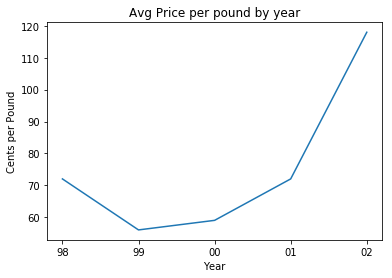

In [105]:
years = ['98', '99', '00', '01', '02']
y = []
for year in years:
    field = '_Average_Price per_Pound_{}'.format(year)
    y.append(df_general.loc['AL'][field])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(years, y)
plt.title('Avg Price per pound by year')
ax.set_xlabel('Year')
ax.set_ylabel(labels[5])
plt.show()